In [1]:
# ✅ Install dependencies
%pip install ultralytics opencv-python albumentations
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os
import cv2
import glob
import random
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO

print("✅ GPU available:", torch.cuda.is_available())
print("🖥️  Current GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# ✅ Dataset root
DATA_DIR = "E:/Work/KSA/Model1/DatasetV1"
AUG_SPLIT = "train_aug"

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
✅ GPU available: True
🖥️  Current GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
# ✅ Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.7),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2),
    A.HueSaturationValue(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# ✅ Create folders for augmented data
os.makedirs(f"{DATA_DIR}/{AUG_SPLIT}/images", exist_ok=True)
os.makedirs(f"{DATA_DIR}/{AUG_SPLIT}/labels", exist_ok=True)

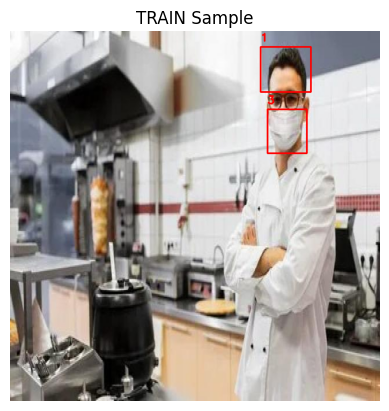

In [3]:
# ✅ Function to show a random sample with bounding boxes
def show_random_sample(split="train"):
    img_path = random.choice(glob.glob(f"{DATA_DIR}/{split}/images/*.jpg"))
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x_center, y_center, w, h = map(float, line.strip().split())
                h_img, w_img = img.shape[:2]
                x_center *= w_img
                y_center *= h_img
                w *= w_img
                h *= h_img
                x1 = int(x_center - w / 2)
                y1 = int(y_center - h / 2)
                x2 = int(x_center + w / 2)
                y2 = int(y_center + h / 2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, str(int(cls)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{split.upper()} Sample")
    plt.show()

# ✅ Display a random sample
show_random_sample("train")

# Class 0: No Mask
# Class 1: No Hairnet
# Class 2: Hairnet
# Class 3: Mask

In [4]:
# ✅ Data augmentation function
def augment_and_save(img_path, label_path, out_split="train_aug", max_augs=3):
    img = cv2.imread(img_path)
    h_img, w_img = img.shape[:2]

    with open(label_path, 'r') as f:
        lines = f.readlines()

    bboxes = []
    class_labels = []
    for line in lines:
        cls, x, y, w, h = map(float, line.strip().split())
        bboxes.append([x, y, w, h])
        class_labels.append(int(cls))

    base_name = os.path.basename(img_path).replace(".jpg", "")

    for i in range(max_augs):
        aug_img_name = f"{base_name}_aug{i}.jpg"
        aug_img_path = os.path.join(DATA_DIR, out_split, "images", aug_img_name)
        aug_label_path = os.path.join(DATA_DIR, out_split, "labels", aug_img_name.replace(".jpg", ".txt"))

        if os.path.exists(aug_img_path):
            continue

        transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        aug_img = transformed['image']
        aug_bboxes = transformed['bboxes']
        aug_labels = transformed['class_labels']

        cv2.imwrite(aug_img_path, aug_img)
        with open(aug_label_path, 'w') as f:
            for cls_id, bbox in zip(aug_labels, aug_bboxes):
                f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")

In [5]:
# ✅ Run augmentation
for split in ["train"]:
    img_paths = glob.glob(f"{DATA_DIR}/{split}/images/*.jpg")
    for img_path in img_paths:
        if "_aug" in os.path.basename(img_path):
            continue
        label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
        if os.path.exists(label_path):
            augment_and_save(img_path, label_path, out_split=AUG_SPLIT)

print("✅ Augmentation complete.")

✅ Augmentation complete.


In [ ]:
# ✅ Load and train YOLOv8m model
model = YOLO('yolov8m.pt')

model.train(
    data=f"{DATA_DIR}/data.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    name="mask_hairnet_v1",
    project="E:/Work/KSA/Model1",
    device=0
)

100%|██████████| 49.7M/49.7M [00:15<00:00, 3.37MB/s]


New https://pypi.org/project/ultralytics/8.3.170 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=E:/Work/KSA/Model1/DatasetV1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_hairnet_v1, nbs=

100%|██████████| 5.35M/5.35M [00:01<00:00, 2.93MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 823.4236.7 MB/s, size: 42.4 KB)


train: Scanning E:\Work\KSA\Model1\DatasetV1\train\labels.cache... 107 images, 0 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.10.0 ms, read: 294.346.1 MB/s, size: 45.9 KB)


val: Scanning E:\Work\KSA\Model1\DatasetV1\valid\labels.cache... 10 images, 1 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to E:\Work\KSA\Model1\mask_hairnet_v1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to E:\Work\KSA\Model1\mask_hairnet_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.38G      2.269      4.417      2.151         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         10         51      0.336      0.372      0.262      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.54G      2.011      2.518      1.699         51        640: 100%|██████████| 14/14 [00:01<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

                   all         10         51      0.348      0.385      0.334      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.54G      1.968      2.065      1.675         43        640: 100%|██████████| 14/14 [00:01<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]

                   all         10         51       0.36      0.349      0.284      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.54G      1.912      2.005      1.669         36        640: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]

                   all         10         51      0.392      0.367      0.324      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.54G      1.856      1.872      1.661         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]

                   all         10         51      0.698      0.512      0.558      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.54G      1.828      1.808      1.622         34        640: 100%|██████████| 14/14 [00:01<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]

                   all         10         51      0.424      0.459      0.436      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.54G      1.886       1.66      1.665         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.82it/s]

                   all         10         51      0.433      0.442      0.404      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.54G      1.898      2.558       1.76          8        640: 100%|██████████| 14/14 [00:01<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]

                   all         10         51      0.603      0.462      0.556      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.54G      1.975      1.826      1.765         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]

                   all         10         51      0.543      0.606      0.558      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.54G      1.926      1.722      1.688         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.93it/s]

                   all         10         51      0.765      0.413      0.536      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.54G      1.761      1.655      1.678         11        640: 100%|██████████| 14/14 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]

                   all         10         51      0.661      0.585      0.555      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.54G      1.732       1.54      1.646         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]

                   all         10         51      0.891      0.462      0.553      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.54G      1.723      1.421      1.631         40        640: 100%|██████████| 14/14 [00:01<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.18it/s]

                   all         10         51       0.56      0.712      0.675      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.54G      1.705      1.345      1.533         26        640: 100%|██████████| 14/14 [00:01<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.10it/s]

                   all         10         51       0.62      0.721      0.679      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.54G      1.765       1.33      1.604         17        640: 100%|██████████| 14/14 [00:01<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]

                   all         10         51      0.639      0.549       0.65      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.54G      1.699      1.288      1.578         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]

                   all         10         51      0.708      0.658      0.716      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.54G      1.729       1.28      1.577         11        640: 100%|██████████| 14/14 [00:01<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]

                   all         10         51       0.73      0.652      0.692      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.54G      1.643      1.163      1.513         34        640: 100%|██████████| 14/14 [00:01<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

                   all         10         51      0.654      0.602      0.631      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.54G      1.668      1.309      1.574          3        640: 100%|██████████| 14/14 [00:01<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]

                   all         10         51      0.666      0.626      0.654      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.54G      1.607      1.162      1.495         18        640: 100%|██████████| 14/14 [00:01<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]

                   all         10         51      0.799      0.627      0.669      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.54G      1.563      1.074      1.495         45        640: 100%|██████████| 14/14 [00:01<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.12it/s]

                   all         10         51      0.705      0.695      0.753      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.54G      1.544      1.063      1.503         24        640: 100%|██████████| 14/14 [00:01<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.18it/s]

                   all         10         51      0.724        0.7      0.739      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.54G      1.477     0.9842      1.448         17        640: 100%|██████████| 14/14 [00:01<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.81it/s]

                   all         10         51      0.724      0.647      0.735      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.54G      1.488       1.01      1.428         42        640: 100%|██████████| 14/14 [00:01<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]

                   all         10         51        0.7      0.749      0.763      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.54G      1.489      1.055       1.42          6        640: 100%|██████████| 14/14 [00:01<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]

                   all         10         51      0.734      0.731      0.734      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.54G      1.441     0.9665      1.426         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.80it/s]

                   all         10         51      0.771      0.637      0.736      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.54G      1.391     0.9364      1.395         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.94it/s]

                   all         10         51      0.807      0.693      0.737      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.54G      1.337     0.9182      1.417         36        640: 100%|██████████| 14/14 [00:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.65it/s]

                   all         10         51      0.755      0.683      0.738      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.54G      1.336     0.8649      1.329         28        640: 100%|██████████| 14/14 [00:01<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]

                   all         10         51      0.742      0.806      0.796      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.54G      1.316     0.8462      1.356         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.22it/s]

                   all         10         51      0.746      0.701      0.764      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.54G      1.343     0.8472      1.333         32        640: 100%|██████████| 14/14 [00:01<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.76it/s]

                   all         10         51      0.773      0.676      0.746      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.54G      1.303     0.8947      1.392         15        640: 100%|██████████| 14/14 [00:01<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.08it/s]

                   all         10         51      0.769      0.689      0.749      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.54G      1.239     0.8105      1.278         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.75it/s]

                   all         10         51      0.823       0.74      0.775      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.54G      1.217     0.7626       1.33         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]

                   all         10         51      0.797      0.739      0.753      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.54G      1.175     0.7599      1.298         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]

                   all         10         51      0.824      0.709      0.755      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.54G      1.165     0.7572      1.275         23        640: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.90it/s]

                   all         10         51      0.812       0.74      0.752      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.54G      1.202     0.7715      1.263         23        640: 100%|██████████| 14/14 [00:01<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.40it/s]

                   all         10         51      0.799      0.726      0.743       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.54G      1.185     0.7682      1.302         18        640: 100%|██████████| 14/14 [00:01<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]

                   all         10         51      0.865      0.696      0.737      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.54G       1.09     0.6748      1.192         23        640: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]

                   all         10         51      0.867       0.73      0.746       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.54G      1.132     0.6762      1.209         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]

                   all         10         51      0.825      0.754      0.755      0.315


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.54G      1.088     0.6518      1.228          6        640: 100%|██████████| 14/14 [00:02<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.25it/s]

                   all         10         51       0.83      0.811      0.817      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.54G      1.026      0.606      1.193         37        640: 100%|██████████| 14/14 [00:01<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.04it/s]

                   all         10         51      0.905      0.744      0.805      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.54G      1.023     0.6399      1.219         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]

                   all         10         51       0.87       0.79      0.805      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.54G     0.9991     0.6175      1.176         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]

                   all         10         51      0.892      0.793      0.812      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.54G     0.9918     0.6019      1.202         15        640: 100%|██████████| 14/14 [00:01<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.51it/s]

                   all         10         51      0.855      0.768      0.824      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.54G     0.9765     0.5791      1.173         19        640: 100%|██████████| 14/14 [00:01<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.97it/s]

                   all         10         51      0.867       0.73      0.785      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.54G     0.9333     0.5591       1.12         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

                   all         10         51      0.891      0.718      0.796      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.54G     0.9132     0.5453      1.131         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

                   all         10         51      0.883       0.72      0.792      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.54G     0.8995     0.5257      1.116         14        640: 100%|██████████| 14/14 [00:01<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.55it/s]

                   all         10         51      0.879      0.722      0.796      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.54G     0.9273      0.538      1.138         22        640: 100%|██████████| 14/14 [00:01<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]

                   all         10         51      0.889      0.716      0.795      0.342



50 epochs completed in 0.040 hours.
Optimizer stripped from E:\Work\KSA\Model1\mask_hairnet_v1\weights\last.pt, 52.0MB
Optimizer stripped from E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt, 52.0MB

Validating E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt...
Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12282MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


                   all         10         51      0.852      0.745      0.822      0.356
               NO mask          5          6       0.73      0.833      0.858      0.217
             NOhairnet          2         13      0.708      0.561       0.69      0.262
               hairnet          8         14       0.97      0.643       0.79      0.428
                  mask          4         18          1      0.944      0.949      0.516
Speed: 0.2ms preprocess, 9.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to E:\Work\KSA\Model1\mask_hairnet_v1


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000019625E0E4D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [ ]:
# ✅ Export to ONNX
trained_model = YOLO("E:/Work/KSA/Model1/mask_hairnet_v1/weights/best.pt")
trained_model.export(format="onnx", dynamic=True, opset=12)
print("✅ Model exported to ONNX.")

Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CPU (13th Gen Intel Core(TM) i9-13900HX)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (49.6 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success  5.1s, saved as 'E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx' (98.7 MB)

Export complete (5.9s)
Results saved to E:\Work\KSA\Model1\mask_hairnet_v1\weights
Predict:         yolo predict task=detect model=E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx imgsz=640 data=E:/Work/KSA/Model1/DatasetV1/data.yaml  
Visualize:       https://netron.app
✅ Model exported to ONNX.


: 